Lab 5
var 5
Model training and testing.

Библиотеки

In [1]:
import torch
import os
import pandas as pd
import cv2
import glob
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image 

In [2]:
'''
Определяет, будет ли использоваться устройство "cuda" (если доступно) или "cpu" 
Устанавливает seed для генерации случайных чисел и выводит выбранное устройство.
'''
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)
print(device)

cpu


Разделение набора данных на выборки

In [3]:
'''
Создает кастомный датасет для обработки изображений. Класс `CustomDataset` наследует от `torch.utils.data.Dataset` и определяет методы `__init__`, `__len__` и `__getitem__`.
Он загружает изображения из файлового списка, применяет преобразования (если они указаны) и возвращает преобразованные изображения с соответствующими метками.

Создаются экземпляры кастомного датасета для обучающего, тестового и валидационного наборов данных, используя соответствующие списки файлов и преобразования.

Выводит информацию о втором элементе из обучающего датасета и метке первого элемента из валидационного датасета.
'''
val_path = os.path.abspath('val_list')
test_path = os.path.abspath('test_list')
train_path = os.path.abspath('train_list')

df = pd.read_csv('annotations_3.csv', sep=',', header=None)
df = df.drop(df.index[0])
df.drop(0, axis=1, inplace=True)
df.rename(columns={1: 'Absolute_path', 2: 'Class'}, inplace=True)
df.reset_index(inplace=True)
print(df)

for path in [val_path, test_path, train_path]:
    if not os.path.isdir(path):
        os.mkdir(path)

def load_image(df, path, i):
    image_path = os.path.abspath(os.path.join(*df.Absolute_path[i].split("\\")))
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)

for i in range(900, 1000):
    load_image(df, val_path, i)
for i in range(1900, 1999):
    load_image(df, val_path, i)
for i in range(800, 900):
    load_image(df, test_path, i)
for i in range(1800, 1900):
    load_image(df, test_path, i)
for i in range(800):
    load_image(df, train_path, i)

train_list = glob.glob(os.path.join(train_path, '*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg'))

train_list, val_list = train_test_split(train_list, test_size=0.1)

      index            Absolute_path       Class
0         1  dataset_random/5446.jpg  brown bear
1         2  dataset_random/5929.jpg  brown bear
2         3  dataset_random/6474.jpg  brown bear
3         4    dataset_random/82.jpg  brown bear
4         5  dataset_random/1088.jpg  brown bear
...     ...                      ...         ...
1995   1996  dataset_random/5090.jpg  polar bear
1996   1997  dataset_random/7265.jpg  polar bear
1997   1998  dataset_random/1002.jpg  polar bear
1998   1999  dataset_random/2049.jpg  polar bear
1999   2000  dataset_random/6781.jpg  polar bear

[2000 rows x 3 columns]


Проверка

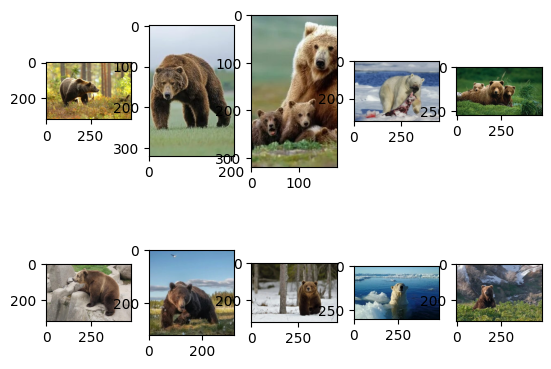

In [4]:
'''
Генерирует 10 случайных индексов из диапазона от 0 до 199 без повторений
Отображает изображения из обучающего списка с использованием библиотеки matplotlib.
'''
random_idx = np.random.choice(200, size=10, replace=False)

fig, axes = plt.subplots(2, 5)
for i, ax in enumerate(axes.flat):
    img = cv2.imread(train_list[random_idx[i]])
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.show()

Увелечение изображений

In [5]:
'''
Определяет наборы преобразований для обучающего, валидационного и тестового наборов данных
таких как изменение размера, случайное обрезание, горизонтальное отражение и преобразование в тензоры.
'''
common_transforms = [
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ]

train_transforms = transforms.Compose(common_transforms)
val_transforms = transforms.Compose(common_transforms)
test_transforms = transforms.Compose(common_transforms)

Загрузка 

In [6]:
'''
Определяет пути к директориям для валидационного, тестового и обучающего наборов данных.
Считывает и предобрабатывает CSV-файл с аннотациями, затем создает директории, если они не существуют.
Определяет функцию для загрузки и сохранения изображений.
Обрабатывает изображения на основе заданных диапазонов.
Создает списки файлов изображений и разделяет обучающий список на обучающий и валидационный наборы данных.
'''
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)

        if self.transform:
            img_transformed = self.transform(img)
        else:
            img_transformed = img

        label = 1 if 'brown bear' in img_path else 0 
        return img_transformed, label

In [7]:
'''
Создание кастомного датасета для обучения, тестирования и валидации модели
C использованием предварительно определенных преобразований.
'''
train_data = CustomDataset(train_list, transform=train_transforms)
test_data = CustomDataset(test_list, transform=test_transforms)
val_data = CustomDataset(val_list, transform=val_transforms)

Проверка

In [8]:
print(train_data[1])
print(val_data[0][1])

(tensor([[[0.8039, 0.8039, 0.8039,  ..., 0.8275, 0.8275, 0.8275],
         [0.8039, 0.8039, 0.8039,  ..., 0.8275, 0.8275, 0.8275],
         [0.8039, 0.8039, 0.8039,  ..., 0.8275, 0.8275, 0.8275],
         ...,
         [0.7608, 0.7608, 0.7569,  ..., 0.9333, 0.9333, 0.9333],
         [0.7529, 0.7529, 0.7529,  ..., 0.9294, 0.9294, 0.9294],
         [0.7529, 0.7529, 0.7529,  ..., 0.9294, 0.9294, 0.9294]],

        [[0.6667, 0.6667, 0.6667,  ..., 0.7137, 0.7137, 0.7137],
         [0.6667, 0.6667, 0.6667,  ..., 0.7137, 0.7137, 0.7137],
         [0.6667, 0.6667, 0.6667,  ..., 0.7137, 0.7137, 0.7137],
         ...,
         [0.6902, 0.6902, 0.6902,  ..., 0.6863, 0.6863, 0.6863],
         [0.6863, 0.6863, 0.6902,  ..., 0.6824, 0.6824, 0.6824],
         [0.6863, 0.6863, 0.6902,  ..., 0.6824, 0.6824, 0.6824]],

        [[0.2941, 0.2941, 0.2902,  ..., 0.2431, 0.2431, 0.2431],
         [0.2941, 0.2941, 0.2902,  ..., 0.2431, 0.2431, 0.2431],
         [0.2941, 0.2941, 0.2902,  ..., 0.2431, 0.2431, 0